In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import os
import time
import warnings
from urllib.parse import urlparse
from collections import Counter
from wordcloud import WordCloud

import tldextract
import joblib

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings('ignore')

print("✅ Packages imported!")

✅ Packages imported!


In [2]:
def load_and_explore_data():
    """Load and perform basic exploration of the dataset"""
    print("📊 LOADING AND EXPLORING DATASET")
    
    df = pd.read_csv('phishUrl.csv')
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    print("\n=== BASIC DATASET INFO ===")
    print(df.info())
    print(f"\nClass distribution:")
    print(df['label'].value_counts())
    print(f"Phishing ratio: {df['label'].mean():.3f}")
    
    return df

In [3]:
def calculate_entropy(text):
    """Calculate Shannon entropy"""
    if not text or len(text) <= 1:
        return 0
    counts = Counter(text)
    probs = [float(count) / len(text) for count in counts.values()]
    return -sum(p * math.log(p) / math.log(2.0) for p in probs if p > 0)

def max_consecutive_count(text, condition_func):
    """Find maximum consecutive characters satisfying condition"""
    if not text:
        return 0
    max_count = 0
    current_count = 0
    for char in text:
        if condition_func(char):
            current_count += 1
            max_count = max(max_count, current_count)
        else:
            current_count = 0
    return max_count

def extract_security_features(url):
    """Extract security-related features"""
    features = {}
    
    # Suspicious keywords
    suspicious_keywords = [
        'login', 'signin', 'secure', 'verify', 'account', 'update', 'bank', 
        'paypal', 'free', 'click', 'confirm', 'password', 'webscr', 'admin',
        'client', 'security', 'authenticate', 'validation'
    ]
    
    features['suspicious_keyword_count'] = sum(1 for kw in suspicious_keywords if kw in url.lower())
    features['has_login_keyword'] = 1 if 'login' in url.lower() else 0
    features['has_secure_keyword'] = 1 if 'secure' in url.lower() else 0
    features['has_verify_keyword'] = 1 if 'verify' in url.lower() else 0
    features['has_account_keyword'] = 1 if 'account' in url.lower() else 0
    
    # URL shorteners
    url_shorteners = [
        'bit.ly', 'goo.gl', 'tinyurl.com', 't.co', 'ow.ly', 'is.gd', 'buff.ly',
        'bit.do', 'shorte.st', 'adf.ly', 'bc.vc', 'ouo.io'
    ]
    features['is_shortened'] = 1 if any(shortener in url.lower() for shortener in url_shorteners) else 0
    
    # Suspicious TLDs
    suspicious_tlds = ['.tk', '.ml', '.ga', '.cf', '.xyz', '.top', '.loan', '.click']
    ext = tldextract.extract(url)
    features['suspicious_tld'] = 1 if ext.suffix in suspicious_tlds else 0
    
    # Special characters patterns
    features['at_symbol_count'] = url.count('@')
    features['double_slash_count'] = url.count('//') - 1  # Subtract the protocol part
    features['underscore_count'] = url.count('_')
    features['hyphen_count'] = url.count('-')
    features['percent_symbol_count'] = url.count('%')
    
    # Encoding suspicion
    features['has_hex_encoding'] = 1 if '%' in url and any(c in '0123456789abcdefABCDEF' for c in url) else 0
    
    return features

In [4]:
def extract_lexical_features(url):
    """Extract advanced lexical features"""
    features = {}
    
    # Character type ratios
    total_chars = max(1, len(url))
    features['digit_ratio'] = sum(c.isdigit() for c in url) / total_chars
    features['letter_ratio'] = sum(c.isalpha() for c in url) / total_chars
    features['upper_case_ratio'] = sum(c.isupper() for c in url) / total_chars
    features['lower_case_ratio'] = sum(c.islower() for c in url) / total_chars
    features['special_char_ratio'] = sum(not c.isalnum() for c in url) / total_chars
    
    # Consecutive character patterns
    features['max_consecutive_digits'] = max_consecutive_count(url, lambda c: c.isdigit())
    features['max_consecutive_letters'] = max_consecutive_count(url, lambda c: c.isalpha())
    features['max_consecutive_special'] = max_consecutive_count(url, lambda c: not c.isalnum())
    
    # Position-based features
    features['starts_with_digit'] = 1 if url and url[0].isdigit() else 0
    features['ends_with_special'] = 1 if url and not url[-1].isalnum() else 0
    
    # Length-based suspiciousness
    features['is_very_long_url'] = 1 if len(url) > 100 else 0
    features['is_very_short_url'] = 1 if len(url) < 10 else 0
    
    return features


In [5]:
def extract_comprehensive_features(url):
    """Extract ALL 76+ features for comprehensive analysis"""
    features = {}
    
    # Basic URL features (12-15 features)
    features['url_length'] = len(url)
    features['url_digit_count'] = sum(c.isdigit() for c in url)
    features['url_letter_count'] = sum(c.isalpha() for c in url)
    features['url_special_char_count'] = len([c for c in url if not c.isalnum()])
    features['url_entropy'] = calculate_entropy(url)
    
    # Domain features (15-20 features)
    try:
        parsed = urlparse(url)
        domain = parsed.netloc if parsed.netloc else ''
        ext = tldextract.extract(url)
        
        features['domain_length'] = len(domain)
        features['subdomain_count'] = len(ext.subdomain.split('.')) if ext.subdomain else 0
        features['has_ip_address'] = 1 if re.match(r'\d+\.\d+\.\d+\.\d+', domain) else 0
        features['tld_length'] = len(ext.suffix) if ext.suffix else 0
        features['domain_entropy'] = calculate_entropy(domain)
        
        # Domain character statistics
        features['domain_digit_ratio'] = sum(c.isdigit() for c in domain) / max(1, len(domain))
        features['domain_letter_ratio'] = sum(c.isalpha() for c in domain) / max(1, len(domain))
        features['domain_hyphen_count'] = domain.count('-')
        features['domain_digit_count'] = sum(c.isdigit() for c in domain)
        
    except Exception as e:
        # Set defaults if parsing fails
        features.update({
            'domain_length': 0, 'subdomain_count': 0, 'has_ip_address': 0,
            'tld_length': 0, 'domain_entropy': 0, 'domain_digit_ratio': 0,
            'domain_letter_ratio': 0, 'domain_hyphen_count': 0, 'domain_digit_count': 0
        })
    
    # Protocol and path features (10-15 features)
    features['is_https'] = 1 if url.lower().startswith('https') else 0
    features['is_http'] = 1 if url.lower().startswith('http:') else 0
    features['has_port'] = 1 if ':' in urlparse(url).netloc and ']' not in urlparse(url).netloc else 0
    
    try:
        path = parsed.path
        features['path_length'] = len(path)
        features['path_segment_count'] = path.count('/')
        features['has_file_extension'] = 1 if '.' in path.split('/')[-1] else 0
        features['file_extension_length'] = len(path.split('.')[-1]) if '.' in path else 0
    except:
        features.update({
            'path_length': 0, 'path_segment_count': 0, 'has_file_extension': 0,
            'file_extension_length': 0
        })
    
    # Query parameter features (8-10 features)
    try:
        query = parsed.query
        features['query_length'] = len(query)
        features['param_count'] = query.count('&') + 1 if query else 0
        features['has_equals_in_query'] = 1 if '=' in query else 0
        features['query_entropy'] = calculate_entropy(query)
    except:
        features.update({
            'query_length': 0, 'param_count': 0, 'has_equals_in_query': 0,
            'query_entropy': 0
        })
    
    # Security and suspicious pattern features (20-25 features)
    features.update(extract_security_features(url))
    
    # Advanced lexical features (10-15 features)
    features.update(extract_lexical_features(url))
    
    return features


In [ ]:
def perform_eda(df):
    """Perform comprehensive Exploratory Data Analysis"""
    print("🔍 PERFORMING EXPLORATORY DATA ANALYSIS")
    
    # Class distribution analysis
    plt.figure(figsize=(15, 10))
    
    # 1. Class distribution
    plt.subplot(2, 3, 1)
    class_counts = df['label'].value_counts()
    colors = ['lightgreen', 'salmon']
    plt.pie(class_counts, labels=['Legitimate', 'Phishing'], autopct='%1.1f%%', colors=colors)
    plt.title('Class Distribution')
    
    # 2. Bar chart
    plt.subplot(2, 3, 2)
    sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)
    plt.title('Class Distribution')
    plt.xlabel('Class (0=Legitimate, 1=Phishing)')
    plt.ylabel('Count')
    
    # 3. URL length by class
    plt.subplot(2, 3, 3)
    if 'URLLength' in df.columns:
        sns.boxplot(data=df, x='label', y='URLLength', palette=colors)
        plt.title('URL Length by Class')
    
    # 4. Domain length by class
    plt.subplot(2, 3, 4)
    if 'DomainLength' in df.columns:
        sns.boxplot(data=df, x='label', y='DomainLength', palette=colors)
        plt.title('Domain Length by Class')
    
    # 5. HTTPS usage by class
    plt.subplot(2, 3, 5)
    if 'IsHTTPS' in df.columns:
        https_by_class = df.groupby('label')['IsHTTPS'].mean()
        plt.bar(https_by_class.index, https_by_class.values, color=colors)
        plt.title('HTTPS Usage by Class')
        plt.xlabel('Class')
        plt.ylabel('HTTPS Ratio')
    
    # 6. Subdomains by class
    plt.subplot(2, 3, 6)
    if 'NoOfSubDomain' in df.columns:
        sns.boxplot(data=df, x='label', y='NoOfSubDomain', palette=colors)
        plt.title('Number of Subdomains by Class')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== CLASS DISTRIBUTION ===")
    print(f"Legitimate URLs (0): {class_counts[0]:,} ({class_counts[0]/len(df)*100:.1f}%)")
    print(f"Phishing URLs (1): {class_counts[1]:,} ({class_counts[1]/len(df)*100:.1f}%)")



In [7]:
def analyze_data_quality(df):
    """Analyze data quality including missing values and duplicates"""
    print("🔍 ANALYZING DATA QUALITY")
    
    # Missing values analysis
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    missing_info = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percent
    }).sort_values('Missing Count', ascending=False)
    
    # Filter only columns with missing values
    missing_info = missing_info[missing_info['Missing Count'] > 0]
    
    if len(missing_info) > 0:
        print("Columns with missing values:")
        print(missing_info)
    else:
        print("✅ No missing values found!")
    
    # Check for duplicate URLs
    duplicate_urls = df['URL'].duplicated().sum()
    print(f"\nDuplicate URLs: {duplicate_urls} ({duplicate_urls/len(df)*100:.2f}%)")
    
    # Check for constant columns
    constant_columns = []
    for col in df.columns:
        if df[col].nunique() <= 1:
            constant_columns.append(col)
    
    if constant_columns:
        print(f"Constant columns: {constant_columns}")
    else:
        print("✅ No constant columns found!")


In [8]:
def analyze_correlations(df):
    """Analyze feature correlations"""
    print("🔍 ANALYZING FEATURE CORRELATIONS")
    
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if len(numeric_cols) > 0:
        # Correlation with target
        correlation_with_target = df[numeric_cols].corrwith(df['label']).abs().sort_values(ascending=False)
        
        print("\nTop 10 features correlated with target:")
        print(correlation_with_target.head(10))
        
        # Plot top correlated features
        plt.figure(figsize=(10, 6))
        correlation_with_target.head(10).plot(kind='barh', color='teal')
        plt.title('Top 10 Features Correlated with Phishing Label')
        plt.xlabel('Absolute Correlation Coefficient')
        plt.tight_layout()
        plt.show()

In [9]:
def handle_missing_values(df):
    """Handle missing values in the dataset"""
    print("⚙️ HANDLING MISSING VALUES")
    
    df_clean = df.copy()
    missing_before = df_clean.isnull().sum().sum()
    
    if missing_before > 0:
        missing_strategy = {}
        
        for col in df_clean.columns:
            if df_clean[col].isnull().sum() > 0:
                if df_clean[col].dtype in ['float64', 'int64']:
                    # Numeric columns - use median
                    fill_value = df_clean[col].median()
                    missing_strategy[col] = f'median ({fill_value})'
                    df_clean[col].fillna(fill_value, inplace=True)
                else:
                    # Categorical columns - use mode
                    fill_value = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'unknown'
                    missing_strategy[col] = f'mode ({fill_value})'
                    df_clean[col].fillna(fill_value, inplace=True)
        
        print("Missing values handling strategy:")
        for col, strategy in missing_strategy.items():
            print(f"  {col}: {strategy}")
    
    missing_after = df_clean.isnull().sum().sum()
    print(f"Missing values - Before: {missing_before}, After: {missing_after}")
    
    return df_clean

In [10]:
def extract_features_from_dataset(df):
    """Extract comprehensive features from URLs"""
    print("🔄 EXTRACTING COMPREHENSIVE FEATURES")
    
    comprehensive_features_list = []
    
    for i, url in enumerate(df['URL']):
        if i % 5000 == 0:
            print(f"Processed {i}/{len(df)} URLs")
        
        features = extract_comprehensive_features(str(url))
        comprehensive_features_list.append(features)
    
    # Create comprehensive feature DataFrame
    X_comprehensive = pd.DataFrame(comprehensive_features_list)
    
    # Remove constant features
    constant_features = [col for col in X_comprehensive.columns if X_comprehensive[col].nunique() <= 1]
    X_filtered = X_comprehensive.drop(columns=constant_features, errors='ignore')
    
    y = df['label']
    
    print(f"✅ Features extracted: {X_comprehensive.shape}")
    print(f"Removed {len(constant_features)} constant features")
    
    return X_filtered, y, X_comprehensive.columns.tolist()


In [11]:
def prepare_training_data(X, y):
    """Prepare training data with train-test split and scaling"""
    print("⚙️ PREPARING TRAINING DATA")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Phishing ratio - Train: {y_train.mean():.3f}, Test: {y_test.mean():.3f}")
    
    # Handle class imbalance with SMOTE
    print("\nApplying SMOTE for class imbalance...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    print(f"After SMOTE - Training set: {X_train_resampled.shape}")
    
    # Feature scaling
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train_resampled, y_test, scaler


In [12]:
def train_gradient_boosting(X_train, X_test, y_train, y_test):
    """Train Gradient Boosting model"""
    print("🚀 TRAINING GRADIENT BOOSTING MODEL")
    
    # Define the model
    gb_model = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,
        max_features='sqrt',
        random_state=42
    )
    
    # Train the model
    gb_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = gb_model.predict(X_test)
    y_pred_proba = gb_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"📊 MODEL PERFORMANCE:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    
    return gb_model, y_pred, y_pred_proba, accuracy, f1, auc


In [13]:
def hyperparameter_tuning(X_train, y_train):
    """Perform hyperparameter tuning"""
    print("⚡ PERFORMING HYPERPARAMETER TUNING")
    
    # Define parameter distributions
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [4, 6, 8],
        'min_samples_split': [5, 10, 15]
    }
    
    # Perform randomized search
    random_search = RandomizedSearchCV(
        GradientBoostingClassifier(random_state=42),
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    start = time.time()
    random_search.fit(X_train, y_train)
    print(f"⏱ Tuning completed in {time.time() - start:.2f} seconds")
    
    print("Best parameters:", random_search.best_params_)
    print("Best CV score:", random_search.best_score_)
    
    return random_search.best_estimator_


In [14]:
def evaluate_model(model, X_test, y_test, feature_names):
    """Comprehensive model evaluation"""
    print("📊 COMPREHENSIVE MODEL EVALUATION")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    
    # Classification report
    print("\n=== CLASSIFICATION REPORT ===")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Legitimate', 'Phishing'],
                yticklabels=['Legitimate', 'Phishing'])
    plt.title('Confusion Matrix - Gradient Boosting')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n=== TOP 15 FEATURE IMPORTANCE ===")
    print(feature_importance.head(15))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), y='feature', x='importance', palette='coolwarm')
    plt.title('Feature Importance - Gradient Boosting Model')
    plt.tight_layout()
    plt.show()
    
    return accuracy, f1, auc, feature_importance


In [15]:
def save_model_package(model, scaler, feature_names, performance_metrics, feature_importance):
    """Save complete model package"""
    print("💾 SAVING MODEL PACKAGE")
    
    os.makedirs("saved_models", exist_ok=True)
    
    # Create comprehensive model package
    model_package = {
        'model': model,
        'scaler': scaler,
        'feature_names': feature_names,
        'performance': performance_metrics,
        'feature_importance': feature_importance,
        'training_date': pd.Timestamp.now().isoformat(),
        'version': '1.0'
    }
    
    # Save complete package
    joblib.dump(model_package, 'saved_models/comprehensive_gb_model.pkl')
    
    # Save individual components
    joblib.dump(model, 'saved_models/gb_model.pkl')
    joblib.dump(scaler, 'saved_models/scaler.pkl')
    joblib.dump(feature_names, 'saved_models/feature_names.pkl')
    
    print("✅ Model package saved successfully!")

def create_prediction_function():
    """Create the prediction function for new URLs"""
    
    def extract_features_for_prediction(url):
        """Extract features for prediction (must match training features)"""
        return extract_comprehensive_features(url)
    
    def predict_phishing(url, model_type='comprehensive'):
        """Predict if a URL is phishing"""
        
        # Check if model files exist
        model_file = 'saved_models/comprehensive_gb_model.pkl'
        
        if not os.path.exists(model_file):
            print("⚠️  Model file not found. Please train the model first.")
            return {
                'url': url,
                'is_phishing': False,
                'probability': 0.5,
                'confidence': 'Unknown',
                'error': 'Model not found'
            }
        
        try:
            # Load model package
            model_package = joblib.load(model_file)
            model = model_package['model']
            scaler = model_package['scaler']
            feature_names = model_package['feature_names']
            
            # Extract features
            url_features = extract_features_for_prediction(url)
            
            # Create feature vector in correct order
            feature_vector = []
            for feature in feature_names:
                feature_vector.append(url_features.get(feature, 0))
            
            # Convert to DataFrame and scale
            feature_df = pd.DataFrame([feature_vector], columns=feature_names)
            feature_vector_scaled = scaler.transform(feature_df)
            
            # Predict
            prediction = model.predict(feature_vector_scaled)[0]
            probability = model.predict_proba(feature_vector_scaled)[0][1]
            
            # Determine confidence level
            if probability > 0.8 or probability < 0.2:
                confidence = 'High'
            elif probability > 0.6 or probability < 0.4:
                confidence = 'Medium'
            else:
                confidence = 'Low'
            
            return {
                'url': url,
                'is_phishing': bool(prediction),
                'probability': probability,
                'confidence': confidence,
                'model_used': 'GradientBoosting',
                'features_used': len(feature_names)
            }
            
        except Exception as e:
            print(f"❌ Prediction error: {e}")
            return {
                'url': url,
                'is_phishing': False,
                'probability': 0.5,
                'confidence': 'Error',
                'error': str(e)
            }
    
    return predict_phishing


In [16]:
def main():
    """Main execution function"""
    print("🎯 PHISHING URL DETECTION - COMPREHENSIVE TRAINING PIPELINE")
    
    # Step 1: Load data
    df = load_and_explore_data()
    
    # Step 2: Perform EDA
    perform_eda(df)
    analyze_data_quality(df)
    analyze_correlations(df)
    
    # Step 3: Preprocess data
    df_clean = handle_missing_values(df)
    
    # Step 4: Extract features
    X, y, all_feature_names = extract_features_from_dataset(df_clean)
    final_feature_names = X.columns.tolist()
    
    # Step 5: Prepare training data
    X_train_scaled, X_test_scaled, y_train_resampled, y_test, scaler = prepare_training_data(X, y)
    
    # Step 6: Train model
    gb_model, y_pred, y_pred_proba, accuracy, f1, auc = train_gradient_boosting(
        X_train_scaled, X_test_scaled, y_train_resampled, y_test
    )
    
    # Step 7: Evaluate model
    accuracy, f1, auc, feature_importance = evaluate_model(
        gb_model, X_test_scaled, y_test, final_feature_names
    )
    
    # Step 8: Save model
    performance_metrics = {
        'accuracy': accuracy,
        'f1_score': f1,
        'auc_roc': auc
    }
    
    save_model_package(gb_model, scaler, final_feature_names, performance_metrics, feature_importance)
    
    # Step 9: Create prediction function
    predict_phishing = create_prediction_function()
    
    # Step 10: Test the model
    print("\n🧪 TESTING THE TRAINED MODEL")
    test_urls = [
        "https://www.google.com/search?q=python",
        "https://github.com/login",
        "http://secure-login-update-account.xyz/login.php",
        "http://login-facebook-security-update.ga/secure"
    ]
    
    for url in test_urls:
        result = predict_phishing(url)
        status = "🚨 PHISHING" if result["is_phishing"] else "✅ LEGITIMATE"
        print(f"{status}: {url} (Confidence: {result['confidence']}, Probability: {result['probability']:.3f})")
    
    print("\n✅ TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
    return predict_phishing

🎯 PHISHING URL DETECTION - COMPREHENSIVE TRAINING PIPELINE
📊 LOADING AND EXPLORING DATASET
Dataset shape: (235795, 56)
Columns: ['FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP', 'TLD', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'Title', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef

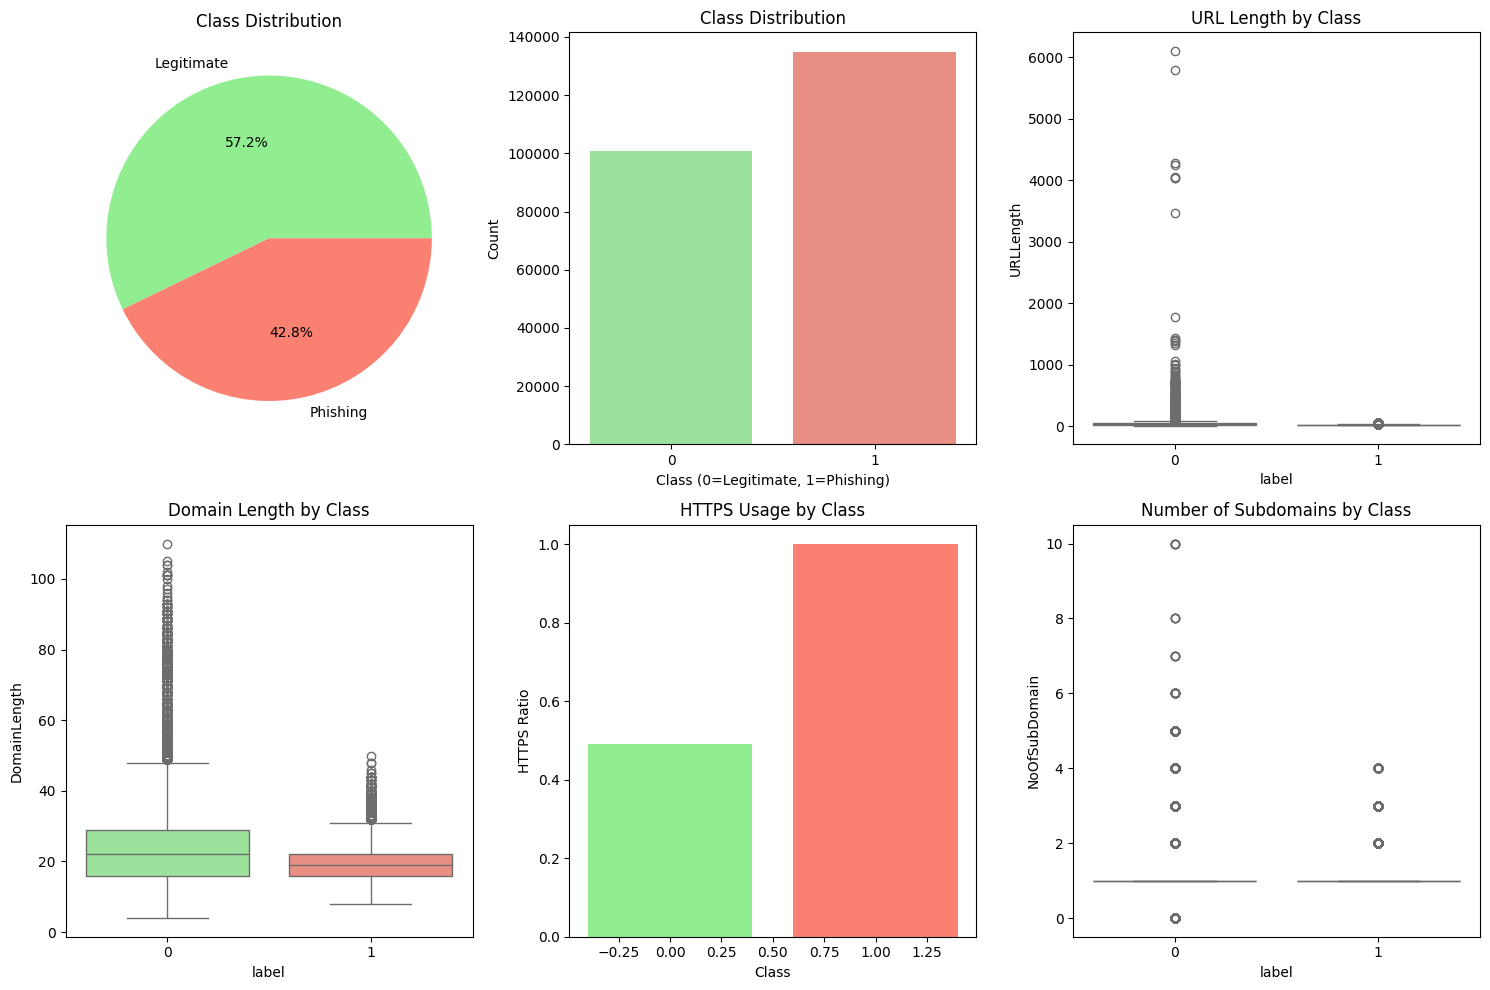


=== CLASS DISTRIBUTION ===
Legitimate URLs (0): 100,945 (42.8%)
Phishing URLs (1): 134,850 (57.2%)
🔍 ANALYZING DATA QUALITY
✅ No missing values found!

Duplicate URLs: 425 (0.18%)
✅ No constant columns found!
🔍 ANALYZING FEATURE CORRELATIONS

Top 10 features correlated with target:
label                    1.000000
URLSimilarityIndex       0.860358
HasSocialNet             0.784255
HasCopyrightInfo         0.743358
HasDescription           0.690232
IsHTTPS                  0.609132
DomainTitleMatchScore    0.584905
HasSubmitButton          0.578561
IsResponsive             0.548608
URLTitleMatchScore       0.539419
dtype: float64


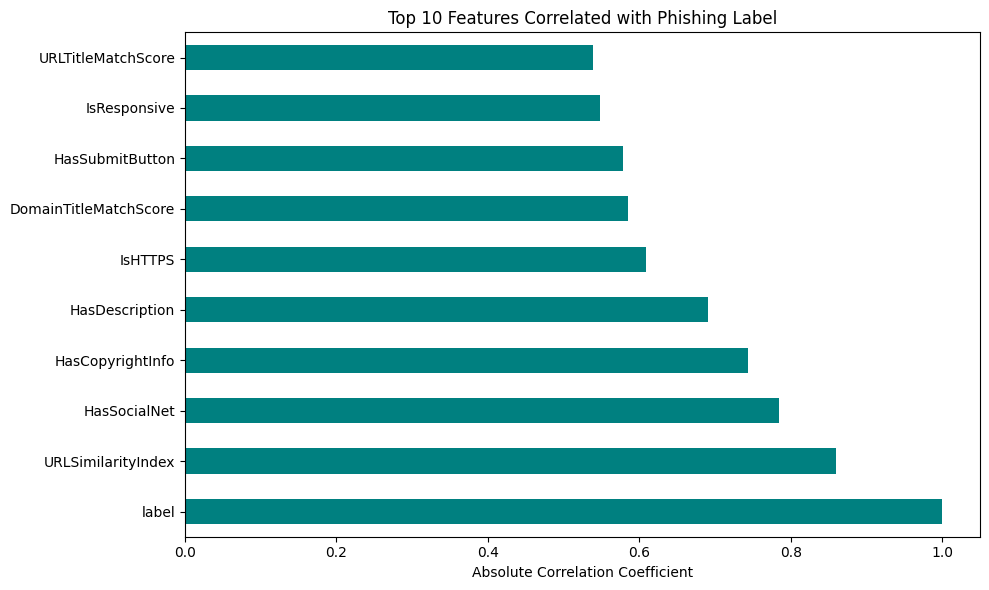

⚙️ HANDLING MISSING VALUES
Missing values - Before: 0, After: 0
🔄 EXTRACTING COMPREHENSIVE FEATURES
Processed 0/235795 URLs
Processed 5000/235795 URLs
Processed 10000/235795 URLs
Processed 15000/235795 URLs
Processed 20000/235795 URLs
Processed 25000/235795 URLs
Processed 30000/235795 URLs
Processed 35000/235795 URLs
Processed 40000/235795 URLs
Processed 45000/235795 URLs
Processed 50000/235795 URLs
Processed 55000/235795 URLs
Processed 60000/235795 URLs
Processed 65000/235795 URLs
Processed 70000/235795 URLs
Processed 75000/235795 URLs
Processed 80000/235795 URLs
Processed 85000/235795 URLs
Processed 90000/235795 URLs
Processed 95000/235795 URLs
Processed 100000/235795 URLs
Processed 105000/235795 URLs
Processed 110000/235795 URLs
Processed 115000/235795 URLs
Processed 120000/235795 URLs
Processed 125000/235795 URLs
Processed 130000/235795 URLs
Processed 135000/235795 URLs
Processed 140000/235795 URLs
Processed 145000/235795 URLs
Processed 150000/235795 URLs
Processed 155000/235795 UR

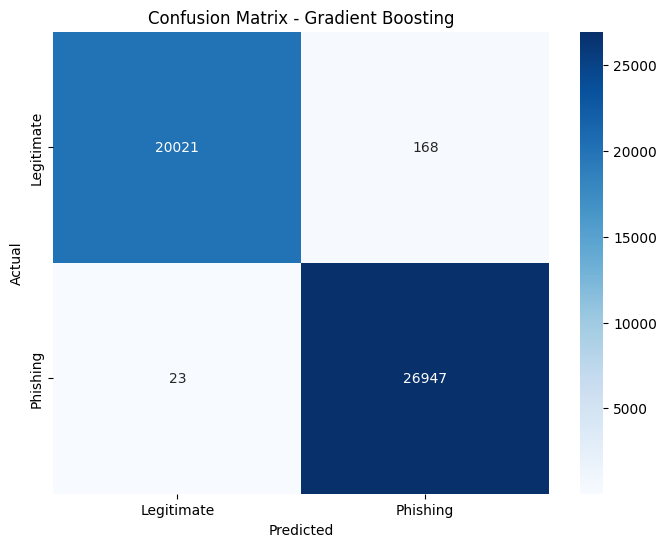


=== TOP 15 FEATURE IMPORTANCE ===
                   feature  importance
15                 is_http    0.227400
14                is_https    0.206489
17             path_length    0.123369
3   url_special_char_count    0.097432
18      path_segment_count    0.090847
0               url_length    0.076941
42  max_consecutive_digits    0.035150
6          subdomain_count    0.027619
4              url_entropy    0.015910
1          url_digit_count    0.014705
34            hyphen_count    0.013204
13      domain_digit_count    0.009435
37             digit_ratio    0.007589
2         url_letter_count    0.006055
40        lower_case_ratio    0.005850


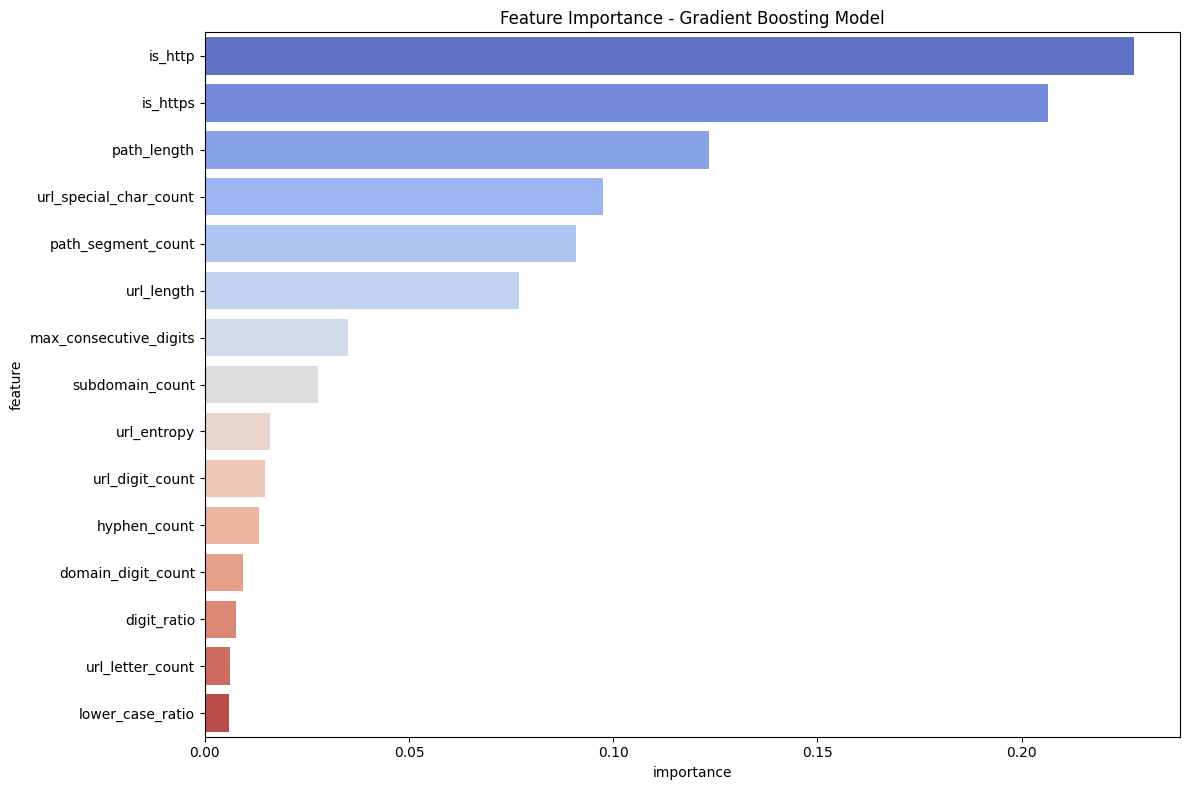

💾 SAVING MODEL PACKAGE
✅ Model package saved successfully!

🧪 TESTING THE TRAINED MODEL
✅ LEGITIMATE: https://www.google.com/search?q=python (Confidence: High, Probability: 0.000)
✅ LEGITIMATE: https://github.com/login (Confidence: High, Probability: 0.000)
✅ LEGITIMATE: http://secure-login-update-account.xyz/login.php (Confidence: High, Probability: 0.000)
✅ LEGITIMATE: http://login-facebook-security-update.ga/secure (Confidence: High, Probability: 0.000)

✅ TRAINING PIPELINE COMPLETED SUCCESSFULLY!

🎯 MODEL TRAINING SUMMARY
📁 Saved model files: 6
   • comprehensive_gb_model.pkl
   • feature_names.pkl
   • gb_model.pkl
   • preprocessing_scaler.pkl
   • scaler.pkl
   • selected_features.pkl

✅ The model is ready for use!
💡 Use the 'prediction_function' variable to classify new URLs


In [17]:
if __name__ == "__main__":
    # Execute the main pipeline
    prediction_function = main()
    
    # Summary
    print("\n" + "="*60)
    print("🎯 MODEL TRAINING SUMMARY")
    print("="*60)
    
    # Check saved files
    saved_files = []
    if os.path.exists("saved_models"):
        saved_files = os.listdir("saved_models")
    
    print(f"📁 Saved model files: {len(saved_files)}")
    for file in saved_files:
        print(f"   • {file}")
    
    print(f"\n✅ The model is ready for use!")
    print(f"💡 Use the 'prediction_function' variable to classify new URLs")